## Setup

In [9]:
import os

# remove any unwanted garbage using the collector
import gc
gc.collect()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn 
import tqdm.notebook as tq
import warnings

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import BertTokenizerFast as BertTokenizer
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

NameError: name '_C' is not defined

In [ ]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Jul 10 16:36:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
|  0%   45C    P8    20W / 450W |   7533MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
https://www.youtube.com/watch?v=vNKIg8rXK6w&ab_channel=rupertai


In [ ]:
# Setup torch
torch.set_float32_matmul_precision('high')
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figs"

In [ ]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Load Dataset

In [ ]:
## load data (takes around 1min30s)
df_train = pd.read_pickle(os.path.join(data_path, "train_dataset_for_DL.pkl"))
print("Train dataset: ", df_train.shape)
df_test = pd.read_pickle(os.path.join(data_path, "test_dataset_for_DL.pkl"))
print("Test dataset: ", df_test.shape)
df_valid100 = pd.read_pickle(os.path.join(data_path, "valid100_dataset_for_DL.pkl"))
print("Validation dataset: ", df_valid100.shape)

Train dataset:  (125220, 103022)
Test dataset:  (29227, 103022)
Validation dataset:  (100, 103022)


In [ ]:
# Check memory space
print("train dataset memory usage: ", df_train.info())
print()
print("ntest dataset memory usage: ", df_test.info())
print()
print("validation dataset memory usage: ", df_valid100.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125220 entries, 0 to 125219
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.8+ MB
train dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29227 entries, 0 to 29226
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 1.1+ MB
ntest dataset memory usage:  None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 103022 entries, !Xóõ (langue) to descr
dtypes: Sparse[int64, 0](103021), object(1)
memory usage: 4.1+ KB
validation dataset memory usage:  None


In [ ]:
# get one row
row_id = 64
label_cols = df_train.columns[:-1]
sample_row = df_train.iloc[row_id]
sample_descr = sample_row.descr
sample_labels = sample_row[label_cols]

print("Description: ", sample_descr)
print("Concepts: ", sample_labels[sample_labels != 0].to_dict())


Description:  La bataille mondiale des matières premières Dans le débat sur un nouvel ordre économique international, les marchés mondiaux des matières premières constituent un enjeu de première importance. Ils conditionnent largement les moyens de financement du développement de pays pauvres et sont un des lieux stratégiques où se joue l'indépendance des pays. L'auteur analyse d'abord les mécanismes et les acteurs des marchés libres, mettant en lumière les limites du jeu libéral de l'offre et de la demande. Son examen des divers systèmes de régulation qui ont été expérimentés l'amènent ensuite à émettre de sérieuses réserves sur l'efficacité des stocks régulateurs. De même, les accords compensatoires (type prêts du FMI) se heurtent-ils à des difficultés théoriques et concrètes de mise en place. La régulation de l'offre n'a véritablement réussi que dans le cas du pétrole. Des solutions plus radicales existent en dehors d'un fonctionnement aménagé du marché : ouverture unilatérale des f

In [ ]:
# # Sample datasets
# df_train = df_train.sample(n=10000, random_state=42)
# print("Train dataset: ", df_train.shape)
# df_test = df_test.sample(n=3000, random_state=42)
# print("Test dataset: ", df_test.shape)

In [ ]:
# # Remove useless columns (labels not used in train dataset - Takes > 5min)
# cols_to_remove = df_train.columns[df_train.sum() == 0]
# len(cols_to_remove)

In [ ]:
# # Remove useless columns
# df_train = df_train.drop(columns=cols_to_remove)
# print("Train dataset:", df_train.shape)
# df_test = df_test.drop(columns=cols_to_remove)
# print("Test dataset:", df_test.shape)
# df_valid100 = df_valid100.drop(columns=cols_to_remove)
# print("Validation dataset:", df_valid100.shape)
# label_cols = df_train.columns[:-1]
# print("Nombre de labels:", len(label_cols))

In [ ]:
# Separate train dataset into train and validation sets for model 
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(df_train, test_size = 0.3)
print(data_train.shape, data_test.shape)

(87654, 103022) (37566, 103022)


## Build the model

In [7]:
# Build Deep Learning Model with BERT/PyTorch
import torch
from transformers import FlaubertModel, FlaubertTokenizer
modelname = 'flaubert/flaubert_base_cased'
flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=False)

RuntimeError: Failed to import transformers.models.flaubert.modeling_flaubert because of the following error (look up to see its traceback):
name '_C' is not defined

In [ ]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 2e-05
THRESHOLD = 0.2 # threshold for the sigmoid

#### Encoding

In [ ]:
# Test tokenizer
text_example = 'Je regarderai la serie à la télévision avec mes enfants ce soir'
# Generate encoding
encodings = tokenizer.encode_plus(
    text_example,
    add_special_tokens=True,
    max_length=20,
    truncation=True,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

# Encodings generate a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html)
print(encodings.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
class RameauLabelDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: tokenizer, max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        descr = " ".join(data_row.descr.split())
        labels = data_row[label_cols]

        inputs = self.tokenizer.encode_plus(
            descr,
            None,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=True,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            "labels": torch.FloatTensor(labels),
            "descr": descr
        }

In [ ]:
# Encode all datasets
train_dataset = RameauLabelDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_LEN
)
test_dataset = RameauLabelDataset(
  df_test,
  tokenizer,
  max_token_len=MAX_LEN
)
valid_dataset = RameauLabelDataset(
  df_valid100,
  tokenizer,
  max_token_len=MAX_LEN
)

In [ ]:
# Check on an item from the dataset
train_dataset = RameauLabelDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_LEN
)
sample_item = train_dataset[0]

print("Description: ", sample_item["descr"])
print("Labels: ", sample_item["labels"])
print("Shape: ", sample_item["input_ids"].shape)

Description:  La culture pour vivre Mort de la culture populaire en France. Mutation des institutions culturelles grâce à une technique de mise en relation des oeuvres et d'un public, et qui tend à créer un comportement culturel adapté aux caractéristiques de l'époque
Labels:  tensor([0., 0., 0.,  ..., 0., 0., 0.])
Shape:  torch.Size([256])


In [ ]:
# Test dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,   100, 11828, 10343, 47444,   100, 10102, 10106, 11828, 26247,
         10109,   100,   119,   100, 10143, 22876, 76385, 10107,   100,   100,
         10249, 20850, 10102, 15863, 10109, 23382, 10143, 84248, 64143, 10107,
         10137,   146,   112, 10119, 11347,   117, 10137, 10379, 43924,   100,
           100, 10119, 74686, 55135,   100, 10840,   100, 10102,   154,   112,
           100,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

### Data Loaders

In [ ]:
# Build data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=16
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

### Bert model

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(label_cols))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to("cuda")

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Jul 10 16:42:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
|  0%   46C    P2    70W / 450W |   8981MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [ ]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, labels):
    return torch.nn.BCEWithLogitsLoss()(outputs, labels)

In [ ]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5) 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

In [ ]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, mean loss
    return model, np.mean(losses)

In [ ]:
# Evaluation
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data["labels"].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

    return np.mean(losses)


## Training1
https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_loss = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_loss = train_model(train_data_loader, model, optimizer)
    val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)


Epoch 1/5


  0%|          | 0/3914 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model

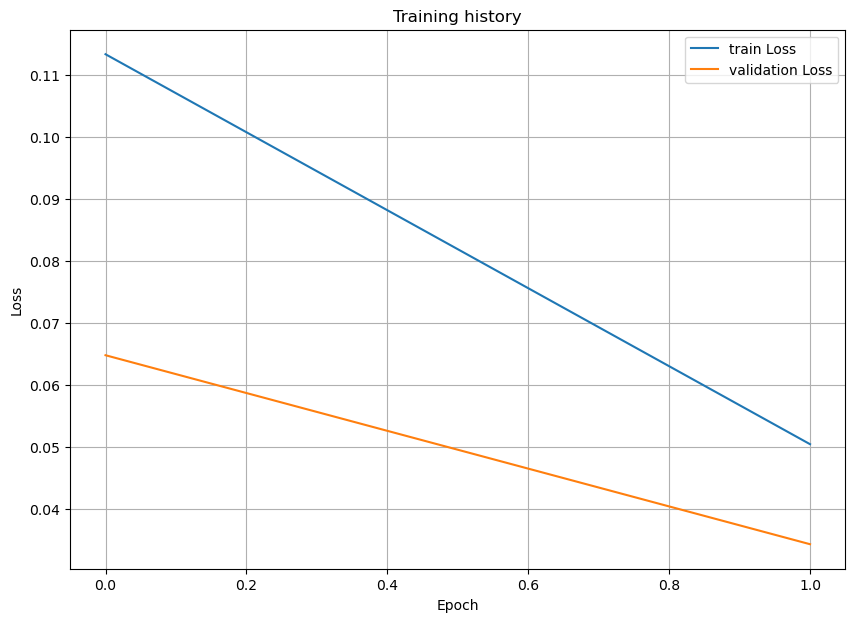

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_loss'], label='train Loss')
plt.plot(history['val_loss'], label='validation Loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

## Evaluation1

In [ ]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(output_path,"MLTC_BERTmultiLingual_model_state.bin")))
model = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    descr = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        descr = data["descr"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["labels"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        descr.extend(descr)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return descr, predictions, prediction_probs, target_values


In [ ]:
descr, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [ ]:
prediction_probs = prediction_probs.cpu().detach().numpy()
predictions = predictions.cpu().detach().numpy()
target_values = target_values.cpu().detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
print("Average doc precision : ", precision_score(target_values, predictions, average="samples", zero_division=0))
print("Average doc recall : ", recall_score(target_values, predictions, average="samples", zero_division=0))
print("Average doc F1score : ", f1_score(target_values, predictions, average="samples", zero_division=0))
print("Average doc Jaccard index : ", jaccard_score(target_values, predictions, average="samples", zero_division=0))

Average doc precision :  0.0
Average doc recall :  0.0
Average doc F1score :  0.0
Average doc Jaccard index :  0.0


In [ ]:
# Prediction
idx = 25
print("Description: ", descr[idx])
pred_probs =print("Predicted Concept: ", label_cols[prediction_probs[idx] > 0.08])
print("Sudoc Indexation: ", label_cols[target_values[idx] == 1])

Description:  Trois histoires de Blanche-Neige : racontées dans le monde Trois versions très différentes du conte dit de "Blanche-Neige" : En Bretagne, La petite Toute-Belle : une mère est si jalouse de sa fille qu’elle demande à la bonne de la pousser dans le puits…En Grèce, Lune d’or : Pommette et Grenadette, jalouses de la beauté de leur soeur Lune d’or, décident de s’en débarrasser…En Allemagne, Blanche-Neige : la version intégrale des frères Grimm, ou comment une jeune fille blanche comme neige, rose comme sang et aux cheveux noirs comme l’ébène, sera recueillie par sept nains des bois.
Predicted Concept:  Index(['Littérature et danse', 'Maisons de retraite', 'Plis', 'Rosée'], dtype='object')
Sudoc Indexation:  Index(['Aspect social', 'Relations hommes-femmes'], dtype='object')


In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

In [ ]:
len(prediction_probs)

3000

In [ ]:
len(target_values)

3000

In [ ]:
target_values

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test()

In [ ]:
# Predictions
trained_model = RameauLabelTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(label_cols)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
# Evaluation
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = RameauLabelDataset(
  df_valid100,
  tokenizer,
  max_token_len=MAX_LEN
)

predictions = []
labels = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

## Metrics

In [ ]:
# Classification report
y_pred = predictions.numpy()
y_true = target_values.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=label_cols,
  zero_division=0
))

                                                                                              precision    recall  f1-score   support

                                                                             'Ūd, Musique d'       0.00      0.00      0.00         0
                                                11 septembre 2001, Attentats du (États-Unis)       0.00      0.00      0.00         0
                                                                      5G (téléphonie mobile)       0.00      0.00      0.00         0
                                                                         AJAX (informatique)       0.00      0.00      0.00         0
                                                          ASP.NET (langage de programmation)       0.00      0.00      0.00         0
                                                                            Abandon d'enfant       0.00      0.00      0.00         0
                                                             

In [ ]:
len(y_pred)

3000

In [ ]:
# Accuracy
THRESHOLD = 0.3
F1 = torchmetrics.F1Score(task="multilabel", num_labels=len(label_cols), top_k=10)
F1(target_values, predictions)

tensor(0.)

In [ ]:
precision = torchmetrics.Precision(task="multilabel", num_labels=len(label_cols), top_k=10)
precision(target_values, predictions)

tensor(0.)

In [ ]:
recall = torchmetrics.Recall(task="multilabel", num_labels=len(label_cols), top_k=10)
recall(target_values, predictions)

tensor(0.)

In [ ]:
# AUROC
print("AUROC per tag")
for i, name in enumerate(label_cols):
  tag_auroc = torchmetrics.AUROC(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

                                                                                              precision    recall  f1-score   support

                                                                             'Ūd, Musique d'       0.00      0.00      0.00         0
                                                11 septembre 2001, Attentats du (États-Unis)       0.00      0.00      0.00         0
                                                                      5G (téléphonie mobile)       0.00      0.00      0.00         0
                                                                         AJAX (informatique)       0.00      0.00      0.00         0
                                                          ASP.NET (langage de programmation)       0.00      0.00      0.00         0
                                                                            Abandon d'enfant       0.00      0.00      0.00         0
                                                             